In [ ]:
from google.colab import drive
drive.mount('/content/drive') #mount drive
!pip install openvino-colab #install openvino for google colab
import openvino_colab #import it
pip install fastai #install fastai
from fastai.vision import *
from fastai.metrics import accuracy
bs = 16 # make imports from fastai
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!wget  --backups=1 -q https://ceb.nlm.nih.gov/proj/malaria#/malaria_cell_classification_code.zip
!unzip cell_images.zip # downloaded required data now unzip
!mv cell_images train
!mkdir data
!mv train data
path = Path("./data") #prepare and preprocess data
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=128, valid_pct=0.4, bs=16).normalize(imagenet_stats)
tlm = create_cnn(data, models.resnet50, metrics=accuracy) #use transfer learning to create model
tlm.fit_one_cycle(4) # run for 4 cycles and see accuracy
import torch, torchvision # aconvert save to onxx format
dummy_input = torch.randn(1, 3, 128, 128, device= 'cuda' )
onnx_path =  "/content/model_fastai.onnx"
torch.onnx.export(tlm.model, dummy_input, onnx_path, verbose=False)
print('exported to ' + onnx_path) #retrieve activation function, create labels and get stats to normalize images
from fastai import basic_train
print(basic_train._loss_func2activ(learn.loss_func))
with open("blood.classes", 'w') as dc:
  dc.write('\n'.join(data.classes))
with open('/content/norm.txt', 'w') as fd:
  fd.write(repr(imagenet_stats))
images_path = get_image_files(path, recurse=True)[0:10]
images_path
images = [open_image(i) for i in images_path] # see sample images
show_all(images) #make inferences for images
for i, im in enumerate(images):
  p = tlm.predict(im)
  print(images_path[i], p[0], p[2][p[1]].item())


Mounted at /content/drive


In [ ]:
tlm.fit_one_cycle(4) 

epoch,train_loss,valid_loss,accuracy,time
0,0.292479,0.163965,0.939581,01:45
1,0.184545,0.127200,0.956455,01:46
2,0.164395,0.116734,0.959902,01:45
3,0.150029,0.115253,0.958450,01:45


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

### fastai to ONNX Conversion

Model exported to /content/model_fastai.onnx


functools.partial(<function softmax at 0x7fde0fdb10d0>, dim=-1)


### Data Visualization

[PosixPath('data/train/Parasitized/C179P140ThinF_IMG_20151127_153420_cell_183.png'),
 PosixPath('data/train/Parasitized/C68P29N_ThinF_IMG_20150819_134326_cell_124.png'),
 PosixPath('data/train/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_175.png'),
 PosixPath('data/train/Parasitized/C68P29N_ThinF_IMG_20150819_134326_cell_133.png'),
 PosixPath('data/train/Parasitized/C133P94ThinF_IMG_20151004_154158_cell_124.png'),
 PosixPath('data/train/Parasitized/C70P31_ThinF_IMG_20150813_131609_cell_100.png'),
 PosixPath('data/train/Parasitized/C184P145ThinF_IMG_20151203_102543_cell_158.png'),
 PosixPath('data/train/Parasitized/C132P93ThinF_IMG_20151004_152353_cell_164.png'),
 PosixPath('data/train/Parasitized/C91P52ThinF_IMG_20150821_125154_cell_204.png'),
 PosixPath('data/train/Parasitized/C49P10thinF_IMG_20150724_102951_cell_211.png')]

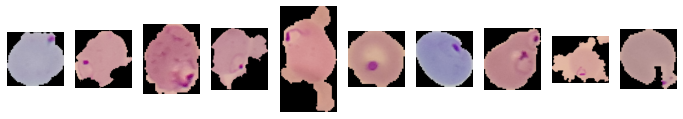

### fastai based inference

In [ ]:
for i, im in enumerate(images):
  p = tlm.predict(im)
  print(images_path[i], p[0], p[2][p[1]].item())

data/train/Parasitized/C179P140ThinF_IMG_20151127_153420_cell_183.png Parasitized 0.9880130290985107
data/train/Parasitized/C68P29N_ThinF_IMG_20150819_134326_cell_124.png Parasitized 0.9928517937660217
data/train/Parasitized/C132P93ThinF_IMG_20151004_151701_cell_175.png Parasitized 0.9991095662117004
data/train/Parasitized/C68P29N_ThinF_IMG_20150819_134326_cell_133.png Parasitized 0.9344249963760376
data/train/Parasitized/C133P94ThinF_IMG_20151004_154158_cell_124.png Parasitized 0.9994333386421204
data/train/Parasitized/C70P31_ThinF_IMG_20150813_131609_cell_100.png Parasitized 0.9625959396362305
data/train/Parasitized/C184P145ThinF_IMG_20151203_102543_cell_158.png Parasitized 0.9974529147148132
data/train/Parasitized/C132P93ThinF_IMG_20151004_152353_cell_164.png Parasitized 0.9999527931213379
data/train/Parasitized/C91P52ThinF_IMG_20150821_125154_cell_204.png Parasitized 0.9617692232131958
data/train/Parasitized/C49P10thinF_IMG_20150724_102951_cell_211.png Parasitized 0.901097714900970

# OpenVINO Installation & Operations


### Reference: [openvino-colab](https://github.com/alihussainia/openvino-colab)

In [ ]:
!pip install openvino-colab

In [ ]:
import openvino_colab

In [ ]:
install_dir = "/opt/intel/openvino/"
model_optimizer = "/opt/intel/openvino/deployment_tools/model_optimizer/"
deployment_tools = "/opt/intel/openvino/deployment_tools/"
model_zoo = '/opt/intel/openvino/deployment_tools/open_model_zoo/'

### Intermediate Representation

In [ ]:
!pip install onnx=='1.1.2'

In [ ]:
# create the Intermediate Representation and run inference on the CPU
!source /opt/intel/openvino/bin/setupvars.sh &&\
python3 /opt/intel/openvino/deployment_tools/model_optimizer/mo.py \
   --input_model model_fastai.onnx --output_dir ir --data_type FP32

/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


### Infer.py 

In [ ]:
!cat ./norm.txt

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# generated a python file (to be able to run it as a script with OpenVINO environment
s = r"""
import sys
import os
from argparse import ArgumentParser
import cv2
import numpy as np
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin
import math

# here put the values from the norm.txt file

resnet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
resnet_scale = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(im, h, w):
    assert(h == w == 128)
    sz = 128
    # convert image to [0-1] RGB, Width Height Channel
    im = im.astype(np.float32) / 255
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # resize and crop center
    r,c, *_ = im.shape
    ratio = sz / min(r, c)
    im = cv2.resize(im, 
                    (max(math.floor(c * ratio), sz), max(math.floor(r * ratio), sz)),
                    interpolation=cv2.INTER_AREA)
    startx = math.ceil((im.shape[0] - sz) / 2)
    starty = math.ceil((im.shape[1] - sz) / 2)
    im = im[startx:startx + sz, starty:starty + sz]

    # normalize and convert to Channel Width Height
    im = (im - resnet_mean) / resnet_scale
    im = im.transpose((2, 0, 1))
    return im


parser = ArgumentParser()
parser.add_argument("-m", "--model", help="Path to an .xml file with a trained model.", required=True, type=str)
parser.add_argument("-i", "--input", help="Path to a folder with images or path to an image files", required=True,
                    type=str, nargs="+")
parser.add_argument("-d", "--device",
                    help="Specify the target device to infer on; CPU, GPU, FPGA or MYRIAD is acceptable. Sample "
                         "will look for a suitable plugin for device specified (CPU by default)", default="CPU",
                    type=str)
parser.add_argument("--labels", help="Labels mapping file", default=None, type=str)
parser.add_argument("-nt", "--number_top", help="Number of top results", default=10, type=int)


log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)
args = parser.parse_args()
model_xml = args.model
model_bin = os.path.splitext(model_xml)[0] + ".bin"

# Plugin initialization for specified device and load extensions library if specified
plugin = IEPlugin(device=args.device)
# Read IR
log.info("Loading network files:\n\t{}\n\t{}".format(model_xml, model_bin))
net = IENetwork(model=model_xml, weights=model_bin)

assert len(net.inputs.keys()) == 1, "Sample supports only single input topologies"
assert len(net.outputs) == 1, "Sample supports only single output topologies"

log.info("Preparing input blobs")
input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))
net.batch_size = len(args.input)

# Read and pre-process input images
n, c, h, w = net.inputs[input_blob].shape
images = np.ndarray(shape=(n, c, h, w))
for i in range(n):
    image = cv2.imread(args.input[i])
    image = preprocess(image, h, w)
    images[i] = image

log.info("Loading model to the plugin")
exec_net = plugin.load(network=net)
del net

log.info("Starting inference)")
res = exec_net.infer(inputs={input_blob: images})

log.info("Processing output blob")
res = res[out_blob]
log.info("Top {} results: ".format(args.number_top))
if args.labels:
    with open(args.labels, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
else:
    labels_map = None
for i, probs in enumerate(res):
    probs = np.squeeze(probs)
    
    #### add the softmax layer manually
    probs = np.exp(probs)/sum(np.exp(probs))
    ####
    
    top_ind = np.argsort(probs)[-args.number_top:][::-1]
    print("Image {}".format(args.input[i]))
    for id in top_ind:
        det_label = labels_map[id] if labels_map else "#{}".format(id)
        print("{:.7f} label {}".format(probs[id], det_label))
    print("")

del exec_net
del plugin
"""
with open("infer.py", 'w') as pf:
  pf.write(s)

# Final Inferences 

In [ ]:
!source /opt/intel/openvino/bin/setupvars.sh &&\
 python3 infer.py -d CPU -m ir/model_fastai.xml \
 --labels blood.classes \
 -nt 1 -i {images_path[0]} {images_path[1]} {images_path[2]} {images_path[3]}

/bin/bash: /opt/intel/openvino/bin/setupvars.sh: No such file or directory
